## geo_mozambique_1

In [33]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

import earthpy as et
import earthpy.plot as ep
import earthpy.spatial as es

import osmnx as ox

from bs4 import BeautifulSoup

import fiona

import gdal

import pyproj

import rasterio as rio
from rasterio.plot import show, show_hist
from rasterio.mask import mask

import cartopy as cp
from shapely.geometry import mapping
from pathlib import Path

import requests
import urllib
import urllib.parse

import os
import pathlib

import holoviews as hv
import hvplot.xarray
import hvplot.pandas
import geoviews as gv

from ast import literal_eval

import shapely

from ipyleaflet import Map, basemaps, basemap_to_tiles, TileLayer, SplitMapControl, Polygon

%matplotlib inline

In [2]:
np.random.seed(3)

### Data understanding

#### Acquire shapefiles - Natural Earth

In [3]:
%%bash 
# in terminal, download and unzip 10m country boundaries shapes from Natural Earth #TODO (Lee) - format long url
# wget https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/cultural/ne_10m_admin_0_countries.zip -P ~/Documents/projects_code/geo_mozambique/data/shapes/
# unzip ~/Documents/projects_code/geo_mozambique/data/shapes/ne_10m_admin_0_countries.zip -d ~/Documents/projects_code/geo_mozambique/data/shapes/

In [6]:
# specify directory containing shapefiles
shapes = '/Users/lee/Documents/projects_code/geo_mozambique/data/shapes/ne_10m_admin_0_countries.shp'

In [10]:
# create geodataframe, a pandas-like data structure containing geoseries
gdf = gpd.read_file(shapes)

# inspect geodataframe
gdf.head(3)

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,ADMIN,ADM0_A3,...,NAME_KO,NAME_NL,NAME_PL,NAME_PT,NAME_RU,NAME_SV,NAME_TR,NAME_VI,NAME_ZH,geometry
0,Admin-0 country,5,2,Indonesia,IDN,0,2,Sovereign country,Indonesia,IDN,...,인도네시아,Indonesië,Indonezja,Indonésia,Индонезия,Indonesien,Endonezya,Indonesia,印度尼西亚,(POLYGON ((117.7036079039552 4.163414542001791...
1,Admin-0 country,5,3,Malaysia,MYS,0,2,Sovereign country,Malaysia,MYS,...,말레이시아,Maleisië,Malezja,Malásia,Малайзия,Malaysia,Malezya,Malaysia,马来西亚,(POLYGON ((117.7036079039552 4.163414542001791...
2,Admin-0 country,6,2,Chile,CHL,0,2,Sovereign country,Chile,CHL,...,칠레,Chili,Chile,Chile,Чили,Chile,Şili,Chile,智利,(POLYGON ((-69.51008875199994 -17.506588197999...


In [12]:
# inspect coordinate reference system (CRS)
gdf.crs
# ouput is EPSG code 4326, which is WGS84

{'init': 'epsg:4326'}

In [13]:
# subset shape file to only include country borders of Mozambique
gdf_mozambique = gdf[gdf['ADMIN']=='Mozambique']

In [14]:
# inspect geometry
gdf_mozambique.geometry

122    (POLYGON ((32.11388431800009 -26.8400143429999...
Name: geometry, dtype: object

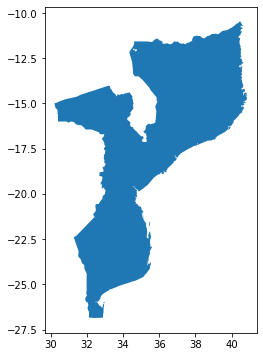

In [32]:
# plot Mozambique shape file 
fig, ax = plt.subplots(figsize=(6,6))

# set aspect to equal when plotting directly with plt
ax.set_aspect('equal')
_ = gdf_mozambique.plot(ax=ax, legend=True)

#### Acquire shapefiles - OSMNX

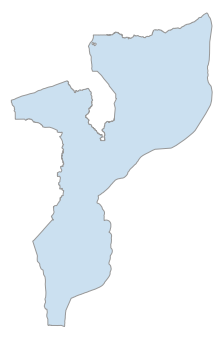

In [18]:
# alternately, use osmnx to get shapefiles from open street map as gpd geodataframe

# get area extent - a polygon - of Mozambique
mozambique_area = ox.gdf_from_place('Mozambique')
_ = ox.plot_shape(ox.project_gdf(mozambique_area))
# graph = ox.graph_from_place(place_name, which_result=2)

In [34]:
%%bash
# inspect tif file #1131100 from cyclone_idai pre-event images from 2019-03-07

# GDAL is a translator library for geospatial data formats
gdalinfo /vsicurl/https://opendata.digitalglobe.com/cyclone_idai/pre-event/2019-03-07/103001008BD57E00/1131100.tif

Driver: GTiff/GeoTIFF
Files: /vsicurl/https://opendata.digitalglobe.com/cyclone_idai/pre-event/2019-03-07/103001008BD57E00/1131100.tif
       /vsicurl/https://opendata.digitalglobe.com/cyclone_idai/pre-event/2019-03-07/103001008BD57E00/1131100.tif.ovr
Size is 19584, 19584
Coordinate System is:
GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0],
    UNIT["degree",0.0174532925199433],
    AUTHORITY["EPSG","4326"]]
Origin = (33.398437500000000,-21.005859375000000)
Pixel Size = (0.000004487879136,-0.000004487879136)
Metadata:
  AREA_OR_POINT=Area
  TIFFTAG_COPYRIGHT=(C) Copyright 2019 DigitalGlobe, Inc., Longmont CO USA 80503
Image Structure Metadata:
  INTERLEAVE=PIXEL
Corner Coordinates:
Upper Left  (  33.3984375, -21.0058594) ( 33d23'54.38"E, 21d 0'21.09"S)
Lower Left  (  33.3984375, -21.0937500) ( 33d23'54.38"E, 21d 5'37.50"S)
Upper Right (  33.486328

In [13]:
# exists = os.path.isfile('foo.vrt')
# if exists:
#     os.system('rm foo.vrt')
#     os.system('gdalbuildvrt foo.vrt /vsicurl/https://opendata.digitalglobe.com/cyclone_idai/pre-event/2019-03-07/103001008BD57E00/1131100.tif')

In [ ]:
# path = pathlib.Path('myfile.txt')
# path.exists()
# path.is_file()

In [14]:
# un-comment to build VRT from a list of datasets
# gdalbuildvrt

In [15]:
# def get_raster_data(url, date):
#     """Get raster open data"""
#     import gdal
#     exists = os.path.isfile('foo.vrt')
#     if exists:
#         os.system('rm foo.vrt')
#         os.system('gdalbuildvrt foo.vrt /vsicurl/http://opendata.digitalglobe.com/cyclone-kenneth/pre-event/)

In [16]:
# get data for cyclone idai

In [17]:
# build a VRT (Virtual Dataset) that is a mosaic of the list of input GDAL datasets. 
# OGR Virtual Format is a driver that transforms features read from other drivers based on criteria specified in an XML control file. 
# Primarily used to derive spatial layers from flat tables with spatial information in attribute columns.
# Also be used to associate coordinate system information with a datasource, merge layers from different datasources 
# into a single data source, or even just to provide an anchor file for access to non-file oriented datasources.

In [ ]:
# STAC metadata not available for DigitalGlobe Open Data
# Create inventory of all images available for Cyclone Idai

#### Scrape images from Digital Global open data

In [76]:
def get_opendata(event_name, filename):
    import requests
    import urllib
    html = request_opendata_event(event_name)
    data = get_opendata_links(html, filename)
    return data

In [77]:
get_opendata('cyclone_idai', 'event_tifs_3')

<_io.TextIOWrapper name='event_tifs_3.txt' mode='a' encoding='UTF-8'>

In [69]:
def request_opendata_event(event_name):
    """Build open data event parsing url call"""
    import requests
    import urllib
    url_base = "https://www.digitalglobe.com/ecosystem/open-data/"
    event=event_name
    html = requests.get(url_base + event_name)
    return html

In [41]:
html = request_opendata_event('cyclone_idai')

In [42]:
html

<Response [200]>

In [75]:
def get_opendata_links(html, filename):
    soup = BeautifulSoup(html.text, "html.parser")
    for link in soup.find_all('a'):
        href = link['href']
        filename = filename
        if href.endswith('.tif'):
            with open(f"{filename}.txt", "a") as f:
                f.write(href+"\n") # write on new line
    return f

In [63]:
def get_dgopendata(event, filename):
    html = request_opendata_event(event)
    data = get_opendata_links(html)
    return data

In [64]:
get_dgopendata("cyclone_idai")

<_io.TextIOWrapper name='event_tifs_2.txt' mode='a' encoding='UTF-8'>

In [65]:
url = "https://www.digitalglobe.com/ecosystem/open-data/cyclone_idai"
html = requests.get(url)
soup = BeautifulSoup(html.text, "html.parser")

for link in soup.find_all('a', href=True):
    href = link['href']
    if href.endswith('.tif'):
        with open("{filename}.txt", "a") as f:
            f.write(href+"\n") # write on new line

In [39]:
# read the list of images
df = pd.read_csv('event_tifs.txt', names=['url'])
df.head(5)

,url
0,https://opendata.digitalglobe.com/cyclone_idai...
1,https://opendata.digitalglobe.com/cyclone_idai...
2,https://opendata.digitalglobe.com/cyclone_idai...
3,https://opendata.digitalglobe.com/cyclone_idai...
4,https://opendata.digitalglobe.com/cyclone_idai...


#### Open file

- a dataset band is an array of values representing the partial distribution of a single variable in 2-dimensional (2D) space. 
- all band arrays of a dataset have the same number of rows and columns. 
- the variable represented by the example dataset’s sole band is Level-1 digital numbers (DN) for the Landsat 8 operational Land Imager (OLI) band 4 (wavelengths between 640-670 nanometers). 
- these values can be scaled to radiance or reflectance values. The array of DN values is 7731 columns wide and 7871 rows high.

In [36]:
# read metadata of raster (tif) file from Digital Globe's open data url pages using rasterio as context mgr
print('Digital Globe open data:')
filepath = 'https://opendata.digitalglobe.com/cyclone_idai/pre-event/2019-03-07/103001008BD57E00/1131100.tif'
with rio.open(filepath) as src:
    print(src.profile)

# inspect metadata:

# ('driver': 'GTiff') = object is a Geotiff
# ('dtype': 'uint8') = the image values are unsigned integer format
# ('nodata': 0.0) = nodata values are not assigned
# ('width': 19584, 'height': 19584) = the image has a dimensions of 19584 x 19584 
# ('count': 3) = is a single band
# ('crs': CRS.from_epsg(4326) = is in UTM coordinates
# (Affine()) = has a simple affine transformation (Affine())
# ('tiled': False) = is not chunked into smaller arrays
# ('interleave': 'pixel') = interleave is pixel

Digital Globe open data:
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 19584, 'height': 19584, 'count': 3, 'crs': CRS.from_epsg(4326), 'transform': Affine(4.48787913602941e-06, 0.0, 33.3984375,
       0.0, -4.48787913602941e-06, -21.005859375), 'tiled': False, 'interleave': 'pixel'}


Decimation factor= 64
array type:  <class 'numpy.ndarray'>
[[  0   0   0 ... 148 198 246]
 [  0   0   0 ... 151 212 254]
 [  0   0   0 ... 146 192 250]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]


Text(0, 0.5, 'Row #')

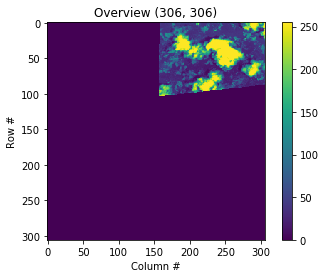

In [28]:
# plot low-res overview by accessing grid of raster values as a np array:

with rio.open(filepath) as src:
   oviews = src.overviews(1) # list of overviews from biggest to smallest
   oview = oviews[-1] # let's look at the smallest thumbnail
   print('Decimation factor= {}'.format(oview)) # use 'decimated read'
   thumbnail = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))

print('array type: ',type(thumbnail))
print(thumbnail)

plt.imshow(thumbnail)
plt.colorbar()
plt.title('Overview {}'.format(thumbnail.shape))
plt.xlabel('Column #')
plt.ylabel('Row #')

In [30]:
# open raster (tif) file
dataset = rio.open('https://opendata.digitalglobe.com/cyclone_idai/pre-event/2019-03-07/103001008BD57E00/1131100.tif')

In [31]:
# plot
plt.imshow(dataset.read(1), cmap='pink')
# plt.image.AxesImage object at 0x...>
plt.show()

RasterioIOError: Read or write failed. /vsicurl/https://opendata.digitalglobe.com/cyclone_idai/pre-event/2019-03-07/103001008BD57E00/1131100.tif, band 1: IReadBlock failed at X offset 0, Y offset 14197: TIFFReadEncodedStrip() failed.

In [ ]:
# plot image
show(dataset)
# plt.axes._subplots.AxesSubplot object at 0x...>
show(dataset.read(), transform=dataset.transform)
# plt.axes._subplots.AxesSubplot object at 0x...>

In [ ]:
# plots of three bands
fig, (axr, axg, axb) = plt.subplots(1,3, figsize=(21,7))
show((dataset, 1), ax=axr, cmap='Reds', title='red channel')

# plt.axes._subplots.AxesSubplot
# show((dataset, 2), ax=axg, cmap='Greens', title='green channel')

# plt.axes._subplots.AxesSubplot
# show((dataset, 3), ax=axb, cmap='Blues', title='blue channel')

# plt.axes._subplots.AxesSubplot

# plt.show()

In [ ]:
# plot color bands histogram
show_hist(
     dataset, bins=50, lw=0.0, stacked=False, alpha=0.3,
     histtype='stepfilled', title="Histogram")

In [ ]:
# plot color bands and associated histogram
fig, (axrgb, axhist) = plt.subplots(1, 2, figsize=(14,7))
show(dataset, ax=axrgb)
plt.axes._subplots.AxesSubplot
show_hist(dataset, bins=50, histtype='stepfilled',
           lw=0.0, stacked=False, alpha=0.3, ax=axhist)
plt.show()


In [ ]:
# inspect width
dataset.width

In [ ]:
#inspect height
dataset.height

In [ ]:
# return spatial bounding box by mapping raster image elements (pixels) map to regions on earth
dataset.bounds
# the image extends from 33.3984375 to 33.486328125 and 21.005859375 to -21.09375 

In [ ]:
# the bounding box values derive from the the affine transformation matrix:
dataset.transform
# affine transformation matrix maps pixel locations in (row, col) coordinates
# to (x, y) spatial positions.

In [ ]:
# calculate the spatial position of the upper left corner of dataset
# by taking product of the Affine matrix and the row and column coordinates ((0, 0),)
of the upper left corner of the dataset is the spatial position of the upper left corner
dataset.transform * (0, 0)

In [ ]:
# the position of the lower right corner is:
dataset.transform * (dataset.width, dataset.height)

In [ ]:
# these coordinate values are relative to the origin of the dataset’s CRS
dataset.crs

In [ ]:
# the CRS and affine transform georeference a raster dataset and make comparable to other datasets

In [ ]:
# inspect number of bands, indexed by convention from 1, not 0
dataset.indexes

In [ ]:
# read band 1
band_1 = dataset.read(1)

# return np array
band_1

#### Data preparation: Make raster using shapefile

In [ ]:
# with fiona.open(mozambique_area, "r") as shapefile:
#     features = [feature["geometry"] for feature in shapefile]

#### Data preparation - Convert a .tif to a .mbtiles using gdal.

In [ ]:
# create an mbtiles file, which will allow us to unpack slippy tile, 256x256 image chips directly 
# this is a good approach for ML training data
# Unpack' from mbtil container to create the actual image tiles

In [ ]:
# import os
# os.system('gdal_translate -of MBTiles 'https://opendata.digitalglobe.com/cyclone_idai/pre-event/2019-03-07/103001008BD57E00/1131100.tif' 1131100.mbtiles')

#### Data understanding

In [ ]:
# get all TMS slippymap tiles that cover bounding boxes with Mapbox SUPERMERCADO

#### Create Pascal VOC data structure as format to present data to CNN Object Detector

In [ ]:
# tmsVOCxml('VOC1900/','buildings',joined)
# flattenTMS('tiles/','19','VOC1900/') 
#     flatten the TMS tile structure to put all images in one directory

In [ ]:
# import os
# cleanupPairs('VOC1900/')

In [ ]:
ls VOC1900/Annotations/*.xml | wc -l

In [ ]:
ls VOC1900/JPEGImages/*.jpg | wc -l